## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- BEZIN Théo
- LAMINE AMIMI Mohamed
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. **Data preprocessing (you are here)**
3. Basic ANN model
4. The CNN model
5. Testing our best model

# 2 - Data preprocessing
As we concluded in the previous workbook, our data needs to be preprocessed before training the models. In this notebook, we will transform our dataset by normalizing it using several functions. This normalized dataset will then be divided into three smaller datasets: a training set to train our models, a validation set to compare our models with each other, and a test set to calculate the performance of our selected model.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>How to normalize?</li>
  <li>Normalizing the dataset</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [174]:
# OS and filesystem
from pathlib import Path

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot

# Sound processing
import librosa
import librosa.display

# Console output
from colorama import Fore, Style
from tqdm.notebook import tqdm

# Misc.
import ast

### A.2 - Package initialization

In [149]:
pyplot.style.use("ggplot")

### A.3 - Constants

In [150]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

# Misc.
RANDOM_STATE = 2077

### A.4 - Utilities

In [151]:
def get_full_path(fold: int, file_name: str) -> Path:
    return URBAN_DATASET_FOLDER / "audio" / f"fold{fold}" / file_name


def load_audio(fold: int, file_name: str, mono: bool = True, sampling_rate: int | None = 22050) -> tuple[numpy.ndarray, int]:
    file_path = get_full_path(fold=fold, file_name=file_name)
    samples, sr = librosa.load(file_path, mono=mono, sr=sampling_rate)

    return samples, sr

### A.5 - Dataset loading
At this point, we will no longer check the integrity of the dataset. Make sure you have a complete dataset before going any further.

In [152]:
data = pandas.read_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K.csv")
print(f"{data.shape[0]} rows, {data.shape[1]} columns")
data.head(n=5)

8732 rows, 8 columns


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## B - How to normalize?
Before we get into the normalization of the dataset, we need to define the format of our output data. Should we feed the models with the raw audio files or should we attempt to classify the waveform of these sounds? We will compare some of these methods below and choose the one we think is best for our purposes.

### B.1 - Raw data
Some people have already tried to build a Multi-Layer Perceptron (MLP) and feed it with raw audio files. While this method can offer good results, the way the data is processed is quite far from the human ear. Since we are trying to produce a model that works in a similar way to the human brain, it may make sense to work with frequencies and amplitudes rather than digital audio data.

### B.2 - Waveform
A waveform is a simple representation of the audio file. It is a two-dimensional graph that shows the amplitude against time and makes it easy to see if there is a sound or not. But this type of graph gives little or no information about the frequencies of the sound.

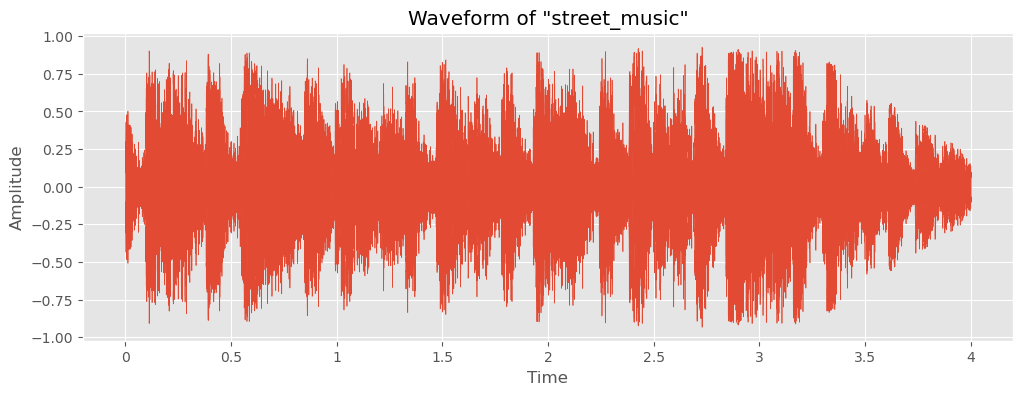

In [158]:
# Initializing variables for the next graphs
random_sound = data.sample(n=1).iloc[0]
random_sound_samples, random_sound_sr = load_audio(fold=random_sound["fold"], file_name=random_sound["slice_file_name"])


def plot_waveform(class_name: str, samples: numpy.ndarray, sampling_rate: int, fig_size: tuple[float, float] = (12, 4)) -> None:
    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.waveshow(samples, sr=sampling_rate, ax=ax)
    pyplot.title(f"Waveform of \"{class_name}\"")
    pyplot.ylabel("Amplitude")
    pyplot.show()


plot_waveform(class_name=random_sound["class"], samples=random_sound_samples, sampling_rate=random_sound_sr)

### B.3 - Spectrum
If we need frequency data, we can use a spectrum. A spectrum is a graph that shows amplitude (or decibels) as a function of frequency, which is the frequency domain instead of the time domain. But in this case, we have lost the time dimension. This dimension is very important for sound reproduction.

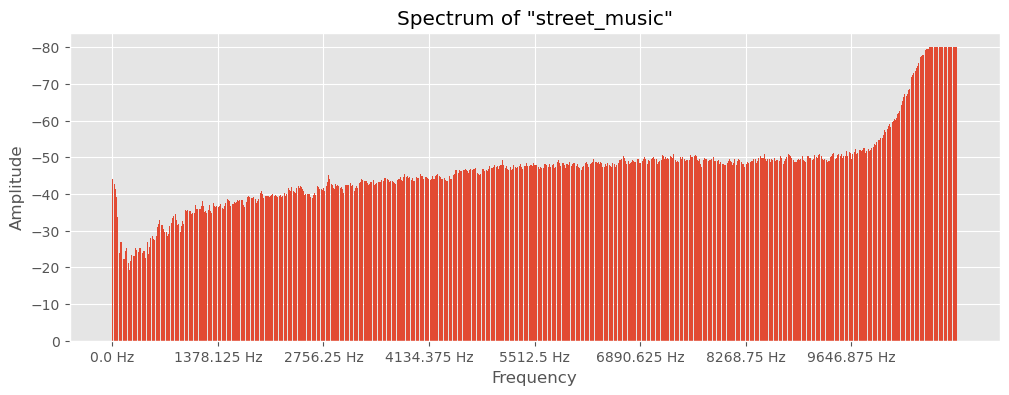

In [163]:
def plot_spectrum(class_name: str, samples: numpy.ndarray, sampling_rate: int, n_fft: int = 2048, hop_length: int = None, fig_size: tuple[float, float] = (12, 4)) -> None:
    if hop_length is None:
        hop_length = (n_fft // 4)

    # Short-time Fourier transform (STFT)
    stft = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(numpy.abs(stft), ref=numpy.max)  # Convert the amplitude to dB
    stft_average = numpy.mean(stft_db, axis=1)  # Calculate the mean

    # Plot the spectrum
    pyplot.subplots(figsize=fig_size)
    pyplot.bar(numpy.arange(stft_average.shape[0]), stft_average)
    x_ticks_positions = [n for n in range(0, (n_fft // 2), (n_fft // 16))]  # Build the xticks positions across the sound frequencies
    x_ticks_labels = [f"{(sampling_rate / 2048) * n} Hz" for n in x_ticks_positions]  # Same for the xticks labels
    pyplot.xticks(x_ticks_positions, x_ticks_labels)
    pyplot.xlabel("Frequency")
    pyplot.ylabel("Amplitude")
    pyplot.gca().invert_yaxis()
    pyplot.title(f"Spectrum of \"{class_name}\"")
    pyplot.show()


plot_spectrum(class_name=random_sound["class"], samples=random_sound_samples, sampling_rate=random_sound_sr)

### B.4 - Spectrogram
We need a sound representation that keep the time dimension and the frequency dimension as well as the amplitude of each frequency. The spectrogram fits our needs. A spectrogram represents time on the x-axis, frequency on the y-axis, and uses color variations to represent the amplitude of each frequency at a given time. The only problem with this one is that spectrograms use a linear frequency scale while the human auditory system uses a logarithmic scale.

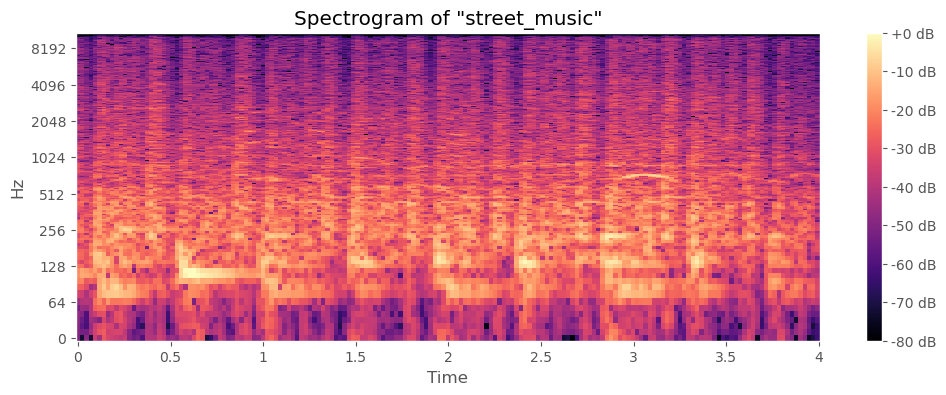

In [164]:
def plot_spectrogram(class_name: str, samples: numpy.ndarray, n_fft: int = 2048, hop_length: int = None, fig_size: tuple[float, float] = (12, 4)) -> None:
    if hop_length is None:
        hop_length = (n_fft // 4)

    samples_normalized = librosa.util.normalize(samples)

    # Short-time Fourier transform (STFT)
    stft = librosa.stft(samples_normalized, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(numpy.abs(stft), ref=numpy.max)  # Convert the amplitude to dB

    # Plot the spectrogram
    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(stft_db, x_axis="time", y_axis="log", ax=ax)
    pyplot.colorbar(ax.get_children()[0], format="%+2.0f dB", ax=ax)
    pyplot.title(f"Spectrogram of \"{class_name}\"")
    pyplot.show()


plot_spectrogram(class_name=random_sound["class"], samples=random_sound_samples)

### B.5 - Mel-Frequency Cepstral Coefficients (MFCCs)
To fix the issue of the spectrogram, we can use a variant of it that use the Mel scale. In fact, we'll use a variant of the Mel spectrogram, the Mel Frequency Cepstral Coefficients (MFCC) also known as MFCC. An MFCC uses a quasi-logarithmic spaced frequency scale, which is more similar to how the human auditory system processes sounds.

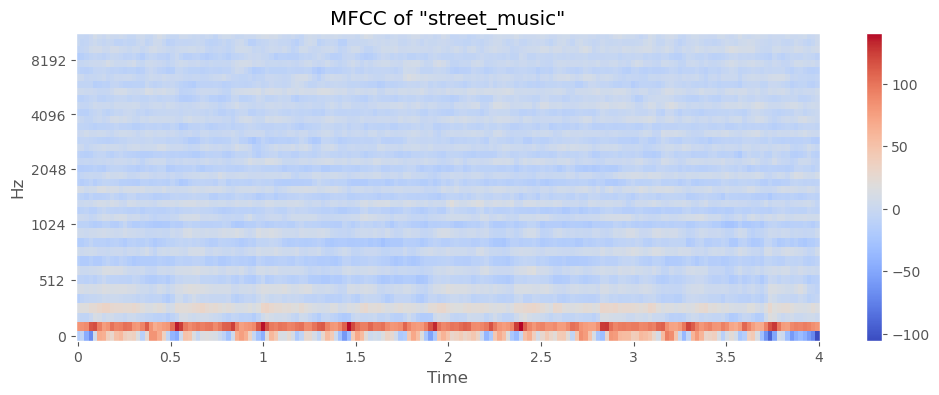

In [166]:
def plot_mfcc_spectrogram(class_name: str, samples: numpy.ndarray, sampling_rate: int, n_mfcc: int = 40, fig_size: tuple[float, float] = (12, 4)) -> None:
    samples_normalized = librosa.util.normalize(samples)
    mfcc = librosa.feature.mfcc(y=samples_normalized, sr=sampling_rate, n_mfcc=n_mfcc)

    # Plot the mfcc
    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(mfcc, x_axis="time", y_axis="mel", ax=ax)
    pyplot.colorbar(ax.get_children()[0], ax=ax)
    pyplot.title(f"MFCC of \"{class_name}\"")
    pyplot.show()


plot_mfcc_spectrogram(class_name=random_sound["class"], samples=random_sound_samples, sampling_rate=random_sound_sr)

### B.6 - Mel spectrogram
We are getting close to our needs with the MFCC, but there is still one small problem. As we can see, the MFCC is almost a single color. This can be a problem when our models try to extract features from it. MFCCs are widely used in speech recognition models. The URBANSOUND dataset contains mechanical sounds, human voices and music. Therefore, the Mel spectrogram will perform better because it retains more features of the original sound.

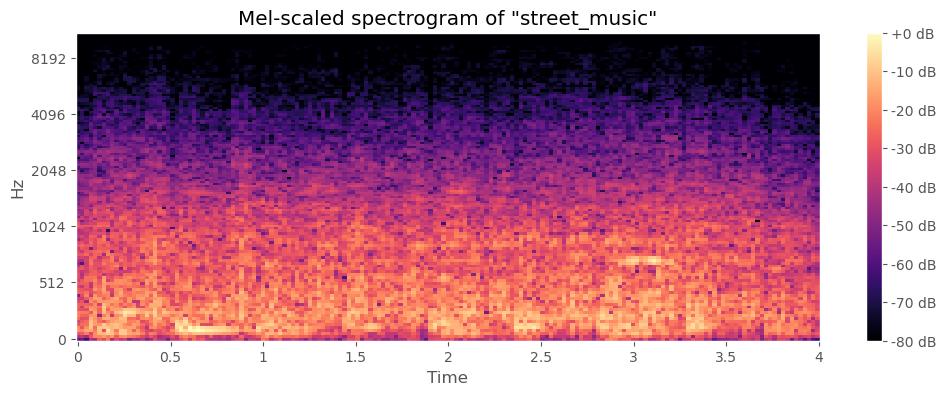

In [168]:
def plot_mel_spectrogram(class_name: str, samples: numpy.ndarray, n_fft: int = 2048, hop_length: int = None, n_mels: int = 128, fig_size: tuple[float, float] = (12, 4)) -> None:
    if hop_length is None:
        hop_length = (n_fft // 4)

    # Short-time Fourier transform (STFT)
    stft = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length)
    mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mels)
    mel_db = librosa.amplitude_to_db(numpy.abs(mel), ref=numpy.max)  # Convert the amplitude to dB

    # Plot the spectrogram
    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(mel_db, x_axis="time", y_axis="mel", ax=ax)
    pyplot.colorbar(ax.get_children()[0], format="%+2.0f dB", ax=ax)
    pyplot.title(f"Mel-scaled spectrogram of \"{class_name}\"")
    pyplot.show()


plot_mel_spectrogram(class_name=random_sound["class"], samples=random_sound_samples)

### B.7 - Which output to choose?
The previous comparisons have clearly shown that the Mel spectrogram is the best option for our needs. But before transforming each sound into a Mel spectrogram, we need to normalize them.

## C - Normalizing the dataset
The previous analysis of the data showed that several properties of the sound (amplitude, number of channels, sampling rate, duration, bit depth) have a large variance.

- **Channel count:** More channels means more data. This leads to a difference between mono and stereo sounds which will affect the learning of the models. To solve this problem, we will merge the stereo audio channels into a single mono channel.
- **Sampling rate:** The maximum recordable frequency of a sound is defined as $samplingRate/2$. Downsampling each file to 22.05 kHz (the default value in `librosa`) will result in a loss of quality, but will also reduce the amount of data per sound. Fewer samples will make our models faster while preserving most of the sound characteristics.
- **Duration:** The type of audio representation we have chosen for the dataset is a spectrogram, an image. Sounds of different duration produce spectrograms of different size or scale. It is therefore important to normalize the audio duration of each file to the longest audio duration of the data set. The padding will consist of an empty sequence added at the end of the audio file.
- **Bit depth:** Bit depth has an impact on quality, as does the sample rate. However, most sound files are 16-bit, which is equivalent to CD quality. Normalizing this property will not affect audio fidelity as much as normalizing the sample rate.

The `librosa` package will help us because, by default, the sampling rate and channels are normalized at loading.

### C.1 - Features extraction
After searching and testing different results, we can start feature extraction. Each audio file will be loaded, normalized and transformed into a Mel spectrogram. All audio files will have these properties:

- **Sampling rate:** 22.05 kHz (`librosa` default)
- **Channel setup:** Mono (`librosa` default)
- **Duration:** Four seconds. The data analysis showed us that no sound lasts longer than four seconds.

In [169]:
def fix_samples_length(samples: numpy.ndarray, sampling_rate: int, duration_sec: int) -> numpy.ndarray:
    required_samples = duration_sec * sampling_rate
    samples_count = len(samples)

    if samples_count < required_samples:  # Pad the audio
        return librosa.util.pad_center(data=samples, size=required_samples, mode="constant")
    elif samples_count > required_samples:  # Truncate the audio
        return librosa.util.fix_length(data=samples, size=required_samples, mode="constant")
    else:  # No operation needed
        return samples


def make_mel_spectrogram(row: pandas.Series, n_fft: int = 2048, hop_length: int = None, n_mels: int = 128, duration_sec: int = None) -> numpy.ndarray:
    if hop_length is None:
        hop_length = (n_fft // 4)

    samples, sampling_rate = load_audio(fold=row["fold"], file_name=row["slice_file_name"])

    if duration_sec:  # Pad/truncate the samples
        samples = fix_samples_length(samples=samples, sampling_rate=sampling_rate, duration_sec=duration_sec)

    samples_normalized = librosa.util.normalize(samples)
    mel = librosa.feature.melspectrogram(y=samples_normalized, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_db = librosa.amplitude_to_db(numpy.abs(mel))
    mel_normalized = librosa.util.normalize(mel_db)

    return mel_normalized


def extract_features(df: pandas.DataFrame, n_mels: int = 128, duration_sec: int = None) -> pandas.DataFrame:
    features_list = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting features..."):
        # Extract features
        class_label = row["class"]
        mel = make_mel_spectrogram(row=row, n_mels=n_mels, duration_sec=duration_sec)

        # Append to the features list
        features_list.append([class_label, mel])

    return pandas.DataFrame(features_list, columns=["class", "mel"])


features = extract_features(df=data, n_mels=128, duration_sec=4)

Extracting features...:   0%|          | 0/8732 [00:00<?, ?it/s]

We will plot a random Mel spectrogram to check if there is no issue.

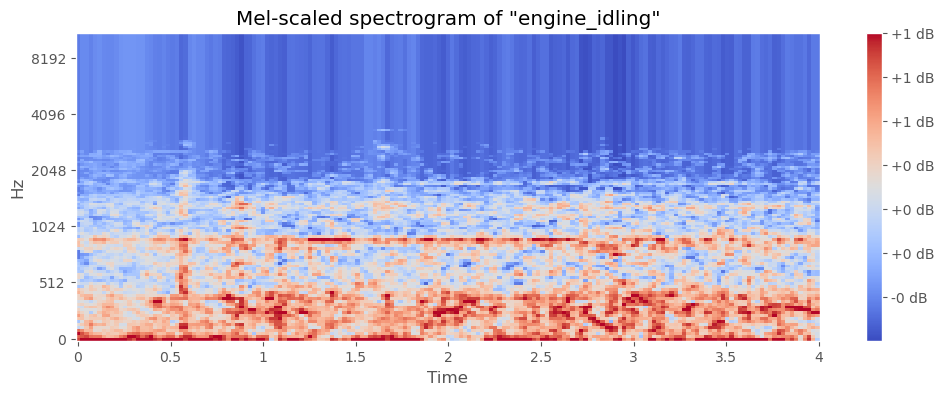

In [172]:
def plot_random_feature(features_df: pandas.DataFrame, fig_size: tuple[float, float] = (12, 4)) -> None:
    random_feature = features_df.sample(n=1).iloc[0]

    fig, ax = pyplot.subplots(figsize=fig_size)
    _ = librosa.display.specshow(random_feature["mel"], x_axis="time", y_axis="mel", ax=ax)
    pyplot.colorbar(ax.get_children()[0], format="%+2.0f dB", ax=ax)
    pyplot.title(f"Mel-scaled spectrogram of \"{random_feature['class']}\"")
    pyplot.show()


plot_random_feature(features)

We can then save the pre-processed data set for later use.

In [173]:
features_x = numpy.array(features["mel"].tolist())
features_y = numpy.array(features["class"].tolist())

features.to_csv(DATA_FOLDER / "features-mel-spectrograms_13-02-23_14-44.csv")  # Save the whole dataset ...
numpy.save(file=str(DATA_FOLDER / "x-mel-spectrograms_13-02-23_14-44"), arr=features_x)  # ... and the split [x, y] versions
numpy.save(file=str(DATA_FOLDER / "y-mel-spectrograms_13-02-23_14-44"), arr=features_y)

## D - Conclusion of the data preprocessing
Our research concluded that the Mel spectrogram is the best option for training our models. However, it may be interesting in the future to test the same models with the MFCC to confirm that the Mel spectrogram performs better on this dataset.

In the next section we will define our first model, a simple artificial neural network (ANN).